<center>
<img src="https://benefits.fastfive.co.kr/wp-content/uploads/2017/12/logo_%ED%8C%A8%EC%8A%A4%ED%8A%B8%EC%BA%A0%ED%8D%BC%EC%8A%A4-600x500.png" width="300" height="300"><br>
</center>

파이썬을 활용한 이커머스 데이터분석_강의를 듣고 따라했던 코딩과 요점을 정리하였다.
 - 출처: [fast campus](https://fastcampus.co.kr/?gclid=CjwKCAjwqvyFBhB7EiwAER786a4FhRzvL9JiiOOTS5TL22ZuXVUKWvF6wWni06h-6fIZ5tp1j0J5phoCoHMQAvD_BwE)




# Chapter.06 프로모션 효율 예측 (Random Forest)

## 분석의 목적


- Random Forest 를 이용하여, 프로모션에 반응할 고객을 예측

- 고객 데이터와 거래 데이터를 통합 활용


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mem = pd.read_csv('./data/member.csv')
tran = pd.read_csv('./data/transaction.csv')

In [3]:
mem.head(5)

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0


#### 데이터 컬럼 살펴보기
- id : 아이디 (의미가 없는 컬럼으로 추후 드랍예정이다.)
- recency : 최근이용을 언제 했었나 (10일전, 6일전 ..)
- zip_code : 우편번호 (한번 가공이 된 상태)
- is_referral : 추천인이 있고 없음 으로 가입을 했는지
- channe : 서비스 이용 채널 (폰, 웹 )
- conversion : 프로모션을 받고 나서 고객이 구입을 했는지 안했는지 (우리가 예측하고자 하는 컬럼/종속변수)

In [4]:
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [5]:
mem.describe()

,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


In [6]:
tran.head()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


#### 데이터 컬럼 살펴보기
- id : 아이디 (의미가 없는 컬럼으로 추후 드랍예정이다.)
- num_item : 한 거래에 몇개에 아이템을 구매 했는지
- total_amount : 총 금액

In [7]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [8]:
tran.describe()

,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


퓨처 엔지니어링을 해보자

In [9]:
tran

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000
...,...,...,...
196831,536246,5,24000
196832,927617,5,26000
196833,927617,3,22000
196834,927617,3,18000


In [10]:
tran['total_amount'] / tran['num_item']

0          6800.000000
1         27000.000000
2          8250.000000
3          7250.000000
4          8250.000000
              ...     
196831     4800.000000
196832     5200.000000
196833     7333.333333
196834     6000.000000
196835     6666.666667
Length: 196836, dtype: float64

평균 금액 컬럼을 하나더 만들고 싶어서, total_amount을 num_item로 나누는 결과값을 시리즈로 나온 것을 확인했다.

이것을 다시 기존 tran 데이터에 컬럼으로 추가해 보자. avg_prie 이란 컬럼으로

In [11]:
tran['avg_price'] = tran['total_amount'] / tran['num_item']

In [12]:
tran

,id,num_item,total_amount,avg_price
0,906145,5,34000,6800.000000
1,906145,1,27000,27000.000000
2,906145,4,33000,8250.000000
3,184478,4,29000,7250.000000
4,394235,4,33000,8250.000000
...,...,...,...,...
196831,536246,5,24000,4800.000000
196832,927617,5,26000,5200.000000
196833,927617,3,22000,7333.333333
196834,927617,3,18000,6000.000000


.groupby() 함수로 id 별로 인덱스해서 평균내어 데이터를 보자.

In [13]:
tran.groupby('id').mean()

,num_item,total_amount,avg_price
id,,,
100001,3.500000,26000.000000,7500.000000
100008,5.000000,26000.000000,5200.000000
100032,2.666667,20666.666667,9366.666667
100036,3.000000,25800.000000,13273.333333
100070,3.250000,21250.000000,8537.500000
...,...,...,...
999932,5.000000,32000.000000,6400.000000
999981,2.000000,22750.000000,12875.000000
999990,3.000000,28000.000000,10388.888889


In [14]:
tran['id'].value_counts()

446874    5
473857    5
384266    5
648461    5
130318    5
         ..
674652    1
670546    1
192229    1
720615    1
789077    1
Name: id, Length: 64000, dtype: int64

tran.groupby('id').mean() 와 tran['id'].value_counts() 의 결과를 합쳐주자.

In [15]:
tran_mean = tran.groupby('id').mean()

In [16]:
tran_cnt = tran['id'].value_counts()

In [17]:
pd.concat([tran_mean, tran_cnt], axis=1)

,num_item,total_amount,avg_price,id
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


In [18]:
tran_df = pd.concat([tran_mean, tran_cnt], axis=1)

id 의 컬럼을 이름을 바꿔주자.

In [19]:
tran_df.rename(columns = {'id':'count'})

,num_item,total_amount,avg_price,count
100001,3.500000,26000.000000,7500.000000,2
100008,5.000000,26000.000000,5200.000000,1
100032,2.666667,20666.666667,9366.666667,3
100036,3.000000,25800.000000,13273.333333,5
100070,3.250000,21250.000000,8537.500000,4
...,...,...,...,...
999932,5.000000,32000.000000,6400.000000,1
999981,2.000000,22750.000000,12875.000000,4
999990,3.000000,28000.000000,10388.888889,3
999995,2.000000,27000.000000,13500.000000,1


이제는 tran 과 mem 데이터를 하나로 합칠 것이다.

In [20]:
mem

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0
2,394235,7,Surburban,1,Web,0
3,130152,9,Rural,1,Web,0
4,940352,2,Urban,0,Web,0
...,...,...,...,...,...,...
63995,838295,10,Urban,0,Web,0
63996,547316,5,Urban,1,Phone,0
63997,131575,6,Urban,1,Phone,0
63998,603659,1,Surburban,1,Multichannel,0


In [21]:
mem.set_index('id', inplace=True)

In [22]:
mem

,recency,zip_code,is_referral,channel,conversion
id,,,,,
906145,10,Surburban,0,Phone,0
184478,6,Rural,1,Web,0
394235,7,Surburban,1,Web,0
130152,9,Rural,1,Web,0
940352,2,Urban,0,Web,0
...,...,...,...,...,...
838295,10,Urban,0,Web,0
547316,5,Urban,1,Phone,0
131575,6,Urban,1,Phone,0


In [23]:
mem.join(tran_df)

,recency,zip_code,is_referral,channel,conversion,num_item,total_amount,avg_price,id
id,,,,,,,,,
906145,10,Surburban,0,Phone,0,3.333333,31333.333333,14016.666667,3
184478,6,Rural,1,Web,0,4.000000,29000.000000,7250.000000,1
394235,7,Surburban,1,Web,0,4.000000,20500.000000,5125.000000,2
130152,9,Rural,1,Web,0,1.750000,20750.000000,14875.000000,4
940352,2,Urban,0,Web,0,3.000000,31000.000000,10333.333333,1
...,...,...,...,...,...,...,...,...,...
838295,10,Urban,0,Web,0,3.500000,26000.000000,8012.500000,4
547316,5,Urban,1,Phone,0,1.800000,17800.000000,11300.000000,5
131575,6,Urban,1,Phone,0,4.000000,30500.000000,7833.333333,2


2 데이터를 합친 것을 하나의 data 로 할당해주자

In [26]:
data = mem.join(tran_df)

결측치 확인

In [28]:
data.isna().sum()

recency         0
zip_code        0
is_referral     0
channel         0
conversion      0
num_item        0
total_amount    0
avg_price       0
id              0
dtype: int64

In [30]:
data.isna().sum() / len(data)

recency         0.0
zip_code        0.0
is_referral     0.0
channel         0.0
conversion      0.0
num_item        0.0
total_amount    0.0
avg_price       0.0
id              0.0
dtype: float64

카테고리 벨류, 즉 텍스트 값 처리하기

우선 유니크값 벨류 확인하기

In [37]:
data['zip_code'].nunique()

3

zip_code에는 3개의 벨류 , channel 에도 3개의 벨류 확인

In [38]:
data['zip_code'].unique()

array(['Surburban', 'Rural', 'Urban'], dtype=object)

In [39]:
data['channel'].nunique()

3

In [40]:
data['channel'].unique()

array(['Phone', 'Web', 'Multichannel'], dtype=object)

.get_dummies() 로 텍스트 벨류 처리하기

In [44]:
pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first = True)

,recency,is_referral,conversion,num_item,total_amount,avg_price,id,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
id,,,,,,,,,,,
906145,10,0,0,3.333333,31333.333333,14016.666667,3,1,0,1,0
184478,6,1,0,4.000000,29000.000000,7250.000000,1,0,0,0,1
394235,7,1,0,4.000000,20500.000000,5125.000000,2,1,0,0,1
130152,9,1,0,1.750000,20750.000000,14875.000000,4,0,0,0,1
940352,2,0,0,3.000000,31000.000000,10333.333333,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
838295,10,0,0,3.500000,26000.000000,8012.500000,4,0,1,0,1
547316,5,1,0,1.800000,17800.000000,11300.000000,5,0,1,1,0
131575,6,1,0,4.000000,30500.000000,7833.333333,2,0,1,1,0


In [45]:
data = pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first = True)

이것으로 data 전처리는 끝났고 준비가 되었다. 모델링을 해보자.

In [47]:
from sklearn.model_selection import train_test_split

In [56]:
X = data.drop('conversion', axis = 1)
y = data['conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100 )

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
model = RandomForestClassifier(max_depth = 10, random_state = 100)

In [59]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=100)

훈련이 끝났으니, 예측을 해보자

In [61]:
pred = model.predict(X_test)

In [62]:
y_test

id
632233    0
412308    0
184792    0
546903    0
113517    0
         ..
629047    0
470260    0
673575    0
345057    0
182726    0
Name: conversion, Length: 19200, dtype: int64

평가도 해보자.

In [64]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [65]:
accuracy_score(y_test, pred)

0.87515625

정확도는 87%로 나쁘지 않게나왔다. 무조건 좋은 치수도 아니다.

In [66]:
confusion_matrix(y_test, pred)

array([[16403,    60],
       [ 2337,   400]])

0 이라고 예상하고 실제가 0 인 수치가: 16403, 1 이라고 예상하고 실제로도 1이 였던 것이 400건, 예상이 0이라고 하고 실제로는 1이 였던 것은 2337건 , 예상은 1이고 실제는 0 이 었던 수치는 60건 이다.

- 전체적인 평가를 해보았을때, 0 이라고 예상했는데 실제는 1이 였던것이 2337이면 정확도가 그렇게 높지 않은 것으로 판단 할 수 있다.

그래서 다른 방법으로 정확도를 높여 보자.

In [67]:
from sklearn.metrics import classification_report

In [69]:
classification_report(y_test, pred)

'              precision    recall  f1-score   support\n\n           0       0.88      1.00      0.93     16463\n           1       0.87      0.15      0.25      2737\n\n    accuracy                           0.88     19200\n   macro avg       0.87      0.57      0.59     19200\nweighted avg       0.87      0.88      0.83     19200\n'

이쁘게 나오지 않는다. 앞에 print를 넣어 출력하자.

In [70]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93     16463
           1       0.87      0.15      0.25      2737

    accuracy                           0.88     19200
   macro avg       0.87      0.57      0.59     19200
weighted avg       0.87      0.88      0.83     19200



1 에대한 recall 값과 f1-score 값이 상대적으로 너무 낮게 나왔다. 

Regressor 로 평가해보기.

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
rf = RandomForestRegressor(max_depth = 10, random_state = 100 )

In [75]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=100)

학습이 된 것으로 예측

In [76]:
rf.predict(X_test)

array([0.        , 0.05858361, 0.        , ..., 0.11632305, 0.        ,
       0.05458311])

In [77]:
pred = rf.predict(X_test)

In [78]:
pd.DataFrame(pred)

,0
0,0.000000
1,0.058584
2,0.000000
3,0.594169
4,0.083316
...,...
19195,0.142431
19196,0.000000
19197,0.116323
19198,0.000000


In [79]:
y_test

id
632233    0
412308    0
184792    0
546903    0
113517    0
         ..
629047    0
470260    0
673575    0
345057    0
182726    0
Name: conversion, Length: 19200, dtype: int64

비교를 하기 위해서 pred의 값이 0 아니면 1로 나와야 한다. 그래서 다음의 추가 작업을 진행해보자.

In [80]:
def conv(x):
    if x >= 0.5:
        return 1
    else:
        return 0
    

In [91]:
pd_result =pd.Series(pred).apply(lambda x: conv(x))

In [92]:
pd_result

0        0
1        0
2        0
3        1
4        0
        ..
19195    0
19196    0
19197    0
19198    0
19199    0
Length: 19200, dtype: int64

또 다른 방법으로는

In [89]:
result = []
for i in pred:
    result.append(conv(i))

In [90]:
result

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


또 다른 방법으로는

In [94]:
result_comp = [1 if x >= 0.5 else 0 for x in pred]

In [95]:
result_comp

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


이제 비교를 해보자.

In [96]:
accuracy_score(y_test, result_comp)

0.8799479166666667

In [97]:
confusion_matrix(y_test, result_comp)

array([[16313,   150],
       [ 2155,   582]])

In [98]:
print(classification_report(y_test, result_comp))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     16463
           1       0.80      0.21      0.34      2737

    accuracy                           0.88     19200
   macro avg       0.84      0.60      0.63     19200
weighted avg       0.87      0.88      0.85     19200



0.5 가 아닌 0.3 으로 정해서, 조절해보자.

In [99]:
result_3 = [1 if x >= 0.3 else 0 for x in pred]

In [100]:
print(classification_report(y_test, result_3))

              precision    recall  f1-score   support

           0       0.90      0.96      0.92     16463
           1       0.55      0.33      0.42      2737

    accuracy                           0.87     19200
   macro avg       0.72      0.64      0.67     19200
weighted avg       0.85      0.87      0.85     19200



비교를 한번해보자 . max_depth 값을 조정해서.

In [103]:
rf = RandomForestRegressor(max_depth = 10, random_state = 100 )
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8799479166666667

In [104]:
rf = RandomForestRegressor(max_depth = 12, random_state = 100 )
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8805729166666667

max_depth = 12로 했을때, 조금더 정확도가 높아졌다. 이번엔 n_estimators = 150 으로 조정해보자

In [106]:
rf = RandomForestRegressor(n_estimators = 150, max_depth = 12, random_state = 100 )
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8800520833333333

결과는 그냥 기본 값이 더 나은 결과를 보여준다.  n_estimators = 100 (기본값은 100이다)

이번엔 min_samples_leaf 값을 조정해보자.

In [108]:
rf = RandomForestRegressor(n_estimators = 100, max_depth = 12, random_state = 100 ,min_samples_leaf = 5)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
result_comp = [1 if x >= 0.5 else 0 for x in pred]

accuracy_score(y_test, result_comp)

0.8810416666666666

조금 더 좋은 값이 나왔다. 하지만 지금의 조건 준것이 가장 best 는 아님을 알아야한다. 여러개의 파라미터 조정을 통해 이것은 언제든 변할 수 있다.

각각의 변수 중요성을 살펴보자.

In [110]:
rf.feature_importances_

array([0.06390282, 0.0229547 , 0.31878145, 0.15857333, 0.25092914,
       0.14468844, 0.00936383, 0.00914032, 0.01179997, 0.009866  ])

In [111]:
X_train.columns

Index(['recency', 'is_referral', 'num_item', 'total_amount', 'avg_price', 'id',
       'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone', 'channel_Web'],
      dtype='object')

그래프로 만들어 보자.

<AxesSubplot:>

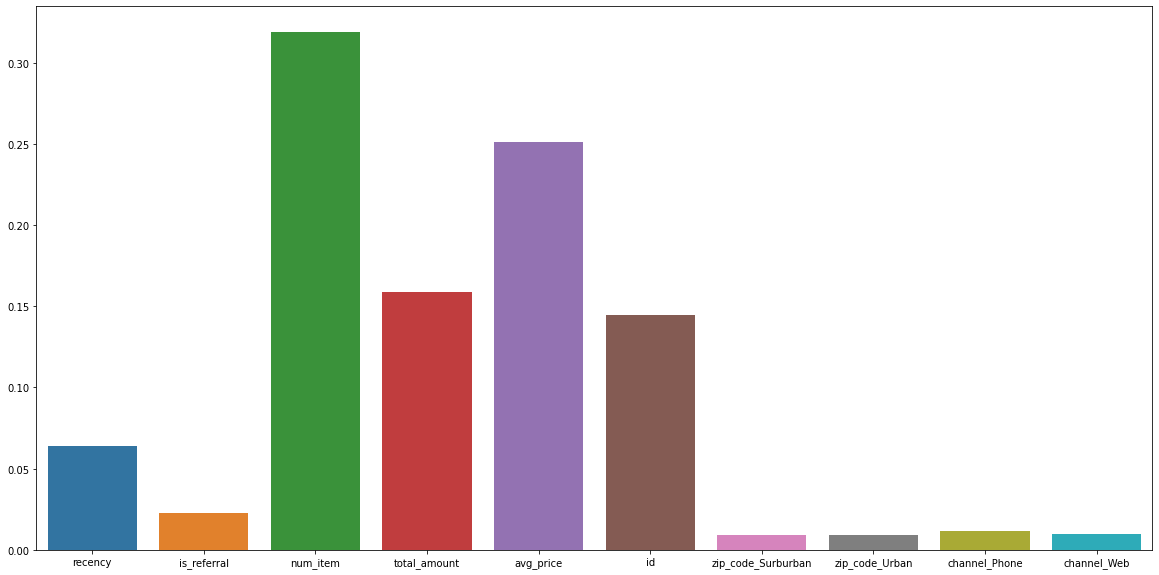

In [114]:
plt.figure(figsize= (20, 10))
sns.barplot(x = X_train.columns, y = rf.feature_importances_)

- 출처 :fast campus_파이썬을 활용한 이커머스 데이터 분석